In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch.autograd import Variable 
import torch.optim as optim 
from torch.utils.data import DataLoader 
from torchvision import transforms
import csv
from torch.utils.data.dataset import Dataset 
import torch.nn as nn 
import torch.nn.functional as F

# 1. Load the data
For more details on how data is loaded, please see `subroutines.py`.

In [2]:
def return_HM_npy(csvfile_path):
    Hs = []
    Ms = []
    with open(csvfile_path, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)  # Skipping the header
        for row in reader:
            Hs.append(float(row[0]))
            Ms.append(float(row[1]))
    return np.array(Hs), np.array(Ms)

def accept_test_middle(H, M, noise_std=0.01, f=None):
    noise = abs(np.random.normal(0, noise_std))
    if (f(H)-noise < M) and (M < f(H)+noise):
        return True
    else:
        return False

def generate_training_data(noise_std=0.004, data_size=10000, Hrange=[0, 0.022], Mrange=[0, 0.11], f=None):
    H_pos_data = []
    M_pos_data = []
    F_pos_data = []
    #
    H_neg_data = []
    M_neg_data = []
    F_neg_data = []
    #
    while True:
        H = np.random.uniform(Hrange[0], Hrange[1])# sampling from uniform distribution.
        M = np.random.uniform(Mrange[0], Mrange[1]) 
        if accept_test_middle(H, M, noise_std, f) and len(F_pos_data)<data_size:
            H_pos_data.append([H])
            M_pos_data.append([M])
            F_pos_data.append([0])
        elif len(F_neg_data)<data_size:
            H_neg_data.append([H])
            M_neg_data.append([M])
            F_neg_data.append([1])
        if len(F_pos_data)==data_size and len(F_neg_data)==data_size:
            break
    return (np.array(H_pos_data), np.array(M_pos_data), np.array(F_pos_data)), (np.array(H_neg_data), np.array(M_neg_data), np.array(F_neg_data))

def plot_all(Hs, Ms, positive_H_M_F, negative_H_M_F, f):
    plt.xlabel('quark mass [GeV]', fontsize=18)
    plt.ylabel(r'$\langle\bar{q}q\rangle$ [GeV$^3$]', fontsize=18)
    #
    plt.plot(positive_H_M_F[0], positive_H_M_F[1], 'b.', label='positive', alpha=0.3)
    plt.plot(negative_H_M_F[0], negative_H_M_F[1], 'g.', label='negative', alpha=0.3)
    hs = np.linspace(np.min(Hs), np.max(Hs), 100)
    plt.plot(hs, f(hs), 'k-', label='data fitting')
    plt.plot(Hs, Ms, 'ro', label='data')
    plt.legend(loc='upper right',
               bbox_to_anchor=(1.05, 0.5, 0.5, .100), )
    plt.show()

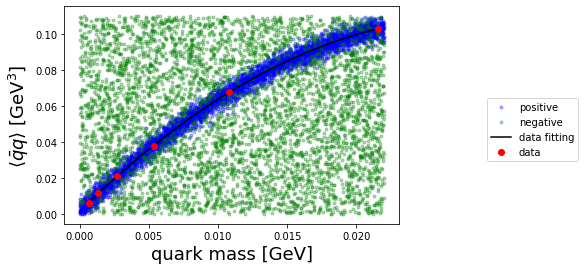

In [3]:
# data values
Hs, Ms = return_HM_npy('q-pp-highT-phys.csv') # data
# data fitting
f = np.poly1d(np.polyfit(Hs, Ms, deg=3)) # data fitting
# data augmentation (H_M_F = (x, y, 0/1) )
positive_H_M_F, negative_H_M_F = generate_training_data(data_size=5000, f=f)
# plot
plot_all(Hs, Ms, positive_H_M_F, negative_H_M_F, f)

## Reformat training data
To train a model by using PyTorch, the training data should be treated by a class called `Dataset`.

In [4]:
class Phi_Pi_DataSet(Dataset):
    ''' class for handling data '''
    def __init__(self, positive_H_M_F, negative_H_M_F, transform=None):
        self.phi = np.concatenate((positive_H_M_F[0], negative_H_M_F[0]),axis=0).astype(np.float32)
        self.Pi = np.concatenate((positive_H_M_F[1], negative_H_M_F[1]),axis=0).astype(np.float32)
        self.ans = np.concatenate((positive_H_M_F[2], negative_H_M_F[2]),axis=0).astype(np.float32)
        self.transform = transform

    def __getitem__(self, index):
        phi = self.phi[index]
        Pi = self.Pi[index]
        ans = self.ans[index]
        if self.transform is not None:
            phi = self.transform(phi)
            Pi = self.transform(Pi)
            ans = self.transform(ans)
        return phi, Pi, ans

    def __len__(self):
        return len(self.phi)

In [5]:
train_d_loader = DataLoader(Phi_Pi_DataSet(
                                           positive_H_M_F=positive_H_M_F, 
                                           negative_H_M_F=negative_H_M_F, 
                                           transform=transforms.Compose([torch.from_numpy])), 
                                           batch_size=100, shuffle=True)

# 2. Make a Neural network

Here we make the network (`Test`) and reguralization coefficients. For more details, please take a look at `network.py`.

In [6]:
# def phi_one_step(phi=None, Pi=None, del_eta=None):
#     ''' phi's eta evolution '''
#     return phi + del_eta*Pi 

# def Pi_one_step(phi=None, Pi=None, Pi_W=None, phi_m2=None, phi3_lam = None, del_eta=None):
#     ''' Pi's eta evolution '''
#     return Pi +(-1)*del_eta*(Pi_W - phi_m2 - phi3_lam)

# def one_step(phi, Pi, Pi_W=None, phi_m2=None, phi3_lam = None, del_eta=None):
#     ''' Evolutions both phi and Pi '''
#     phi2 = phi_one_step(phi, Pi, del_eta)
#     Pi2 = Pi_one_step(phi, Pi, Pi_W=Pi_W, phi_m2=phi_m2, phi3_lam = phi3_lam, del_eta=del_eta)
#     return phi2, Pi2

def onestep(phi, Pi, hh=None, m2=None, lamb=None, del_eta=None):
    phi1 = phi + del_eta*Pi
    Pi1 = phi*m2*del_eta + (1-del_eta*hh)*Pi + del_eta*lamb*(phi1**3)
    return phi1, Pi1

def eta(s, eta_ini, eta_fin, N_layer):
    eta = eta_ini + (eta_fin - eta_ini)*(s-1)/N_layer
    return eta

# functions in final layers

def f(phi, Pi, eta=None):
    ''' returning Pi'''
    F=Pi
    return F

def arctan_scaled(x, center=None, scale=10, tanh=None):
    y = scale*(x-center)
    y = tanh(y)
    return y

def t(x, epsilon=None, tanh=None, dev=.01):
    ''' smoothed bump function '''
    left = -arctan_scaled(x, center=-epsilon, scale=1/dev, tanh=tanh)
    right = arctan_scaled(x, center=epsilon, scale=1/dev, tanh=tanh)
    lf = left+right
    return (lf+2)/2

##### 

class MetricNet(nn.Module):
    ''' class of model to be trained '''
    def __init__(self, Number_of_layers=None, eta_ini=None, eta_fin=None, m2=None, del_eta=None, d=None):
        super(MetricNet, self).__init__()
        # trained parameters
        Hs = []
        for layer_index in range(Number_of_layers):
            Hs.append(nn.Linear(1, 1, bias=False))
        self.Hs = nn.ModuleList(Hs)
        self.adsradius = nn.Linear(1, 1, bias=False)
        self.lamb = nn.Linear(1, 1, bias=False)
        # fixed parameters
        self.one = Variable(torch.ones(1)) # it would be better to use torch.nn.parameter.
        self.N_layers = Number_of_layers
        self.eta_ini = eta_ini
        self.eta_fin = eta_fin
        self.m2 = m2
        self.del_eta = del_eta
        self.d = d

    def show_lamb(self):
        return self.lamb(self.one)
    
    def show_adsradius(self):
        return self.adsradius(self.one)
        
    def penalty(self, coef_list=None):
        if coef_list==None:
            coefs = torch.autograd.Variable(torch.ones(self.N_layers))
        else:
            n_coef_list = np.array(coef_list, dtype=np.float32)
            coefs = torch.autograd.Variable(torch.from_numpy(n_coef_list))
        for i in range(self.N_layers):
            H = self.Hs[i]
            if H==self.Hs[0]:
                # making the metric at boundary as AdS_{d+1} 
                penalty = 0.01*(self.d - H(self.one))**2
                pH = H(self.one)
            else:
                # smoothing penalty
                ## if Einstein equation, use below:
                #penalty = penalty + coefs[i]*(-d**2 + (H(self.one) - pH)/del_eta + pH**2)**2
                penalty = penalty + coefs[i]*(H(self.one) - pH)**2
                pH = H(self.one)
        return penalty
        
    def forward(self, phi=None, Pi=None):
        ''' forward propagation '''
        # initial layer
        alphatilde = self.adsradius(self.one)*(1.7320508/(2*3.1415926))*phi
        betatilde = (self.adsradius(self.one))**3*(3.1415926/1.7320508)*Pi
        phi = alphatilde*(np.exp(-self.eta_ini)) + betatilde*(np.exp(-3*self.eta_ini)) -(1/2)*alphatilde**3*self.lamb(self.one)*self.eta_ini*(np.exp(-3*self.eta_ini))
        Pi = -alphatilde*(np.exp(-self.eta_ini)) -3*betatilde*(np.exp(-3*self.eta_ini)) +(3/2)*alphatilde**3*self.lamb(self.one)*self.eta_ini*(np.exp(-3*self.eta_ini))-(1/2)*alphatilde**3*self.lamb(self.one)*(np.exp(-3*self.eta_ini))
        # intermediate layers
        for H in self.Hs:
            phi, Pi = onestep(phi, Pi, hh=H(self.one), m2=self.m2, lamb=self.lamb(self.one), del_eta=self.del_eta)
        # finaly layer
        f_ = f(phi, Pi, eta=eta(self.N_layers, self.eta_ini, self.eta_fin, self.N_layers))
        final = t(f_, epsilon=.1, tanh=torch.tanh)
        return final
    
    def loss(self, phi=None, Pi=None, answer=None, reg_coef_list=None):
        model_output = self.forward(phi=phi, Pi=Pi)
        loss = F.l1_loss(model_output, answer)**2
        loss = loss + self.penalty(coef_list=reg_coef_list)
        return loss

def init_weights(Model, d):
    ''' for initializations of parameters '''
    # metric (H[layer])
    for i in range(len(Model.Hs)):
        # ipt = initial value for H[i]
        ipt = d
        # noize 
        std = 3
        w = np.random.normal(ipt, std) # sampling from Gaussian
        w = round(w, 10) # it seems to be needed to round w somehow, I don't know why...
        Model.Hs[i].weight.data.fill_(w) # initialization excuted 
    
    # lambda
    lamb = 0.2
    std = 0
    lamb = np.random.normal(lamb, std)
    Model.lamb.weight.data.fill_(lamb)
    
    # AdS radius[GeV^{-1}]
    adsradius = 0.8
    std = 0
    adsradius = np.random.normal(adsradius, std)
    Model.adsradius.weight.data.fill_(adsradius)

lambda: 0.20000000298023224,   AdS radius: 0.800000011920929[1/GeV]
[ 6.6053476  2.6816387 -0.167449   2.7533033  7.4482374  2.7811818
  6.0705996  1.6118475  1.0652463  3.341003   7.437092   4.3801265
  5.28065    0.7334895  0.8513326]


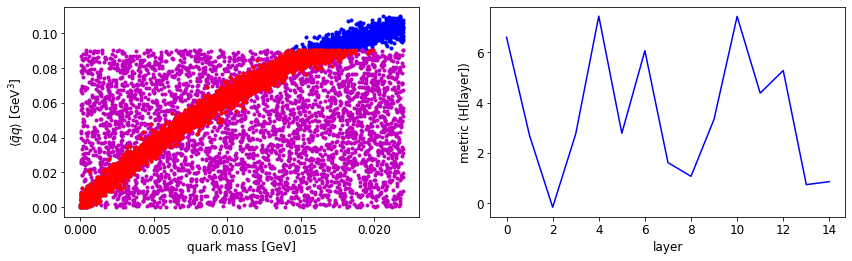

In [81]:
d = 4
m2 = -3 # mass^2
N_layer = 15
eta_fin = 1/N_layer
eta_ini = 1
del_eta = (eta_fin - eta_ini)/N_layer
Test = MetricNet(Number_of_layers=N_layer, eta_ini=eta_ini, eta_fin=eta_fin, m2=m2, del_eta=del_eta,d=d)
init_weights(Test, d)
optimizer = optim.Adam(Test.parameters()) 
Test.train()

print ("lambda: {},   AdS radius: {}[1/GeV]".format(Test.show_lamb().data.numpy()[0], Test.show_adsradius().data.numpy()[0]))
a=[Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layers)]
print(np.array(a))
negx, negy, posx, posy, Hs = plot_phase_and_metric(
                                                           threshold=.1, eta_or_layer='layer',
                                                           positive_H_M_F=positive_H_M_F,
                                                           negative_H_M_F=negative_H_M_F,
                                                           Net=Test
                                                          )

# 3. Train your NN

In [82]:
def plot_phase_and_metric(threshold=None, eta_or_layer='eta', positive_H_M_F=None, negative_H_M_F=None, Net=None):
    NN2_pos_phis = []
    NN2_pos_Pis = []
    
    negative_H = negative_H_M_F[0] #input_data[1]
    negative_M = negative_H_M_F[1] #input_data[3]
    
    phis = Variable(torch.from_numpy(negative_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(negative_M.astype(np.float32)))
    NN2_predicts = Net.forward(phi=phis, Pi=Pis).data.numpy()

    for index in range(len(phis)):
        value = NN2_predicts[index]#NN2.predict([phis[index], Pis[index]])
        if value < threshold:
            NN2_pos_phis.append(negative_H[index])
            NN2_pos_Pis.append(negative_M[index])
        
    NN2_pos_phis_1 = np.array(NN2_pos_phis)
    NN2_pos_Pis_1 = np.array(NN2_pos_Pis)
    ######
    NN2_pos_phis = []
    NN2_pos_Pis = []
    
    positive_H = positive_H_M_F[0]# input_data[0]
    positive_M = positive_H_M_F[1]# input_data[2]
    
    phis = Variable(torch.from_numpy(positive_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(positive_M.astype(np.float32)))
    NN2_predicts = Net.forward(phi=phis, Pi=Pis).data.numpy()

    for index in range(len(phis)):
        value = NN2_predicts[index]#NN2.predict([phis[index], Pis[index]])
        if value < threshold:
            NN2_pos_phis.append(positive_H[index])
            NN2_pos_Pis.append(positive_M[index])
        
    NN2_pos_phis_2 = np.array(NN2_pos_phis)
    NN2_pos_Pis_2 = np.array(NN2_pos_Pis)
    ####
    plt.rcParams["font.size"] = 12
    fig = plt.figure(figsize=(14, 4))
    fig.subplots_adjust(bottom=0.15)
    al = fig.add_subplot(1,2,1)
    ar = fig.add_subplot(1,2,2)
    al.set_xlabel('quark mass [GeV]', fontsize=12)
    al.set_ylabel(r'$\langle \bar{q}q\rangle$ [GeV$^3$]', fontsize=12)
    al.plot(positive_H , positive_M, 'b.', label='Positive')
    #print(NN2_pos_phis_1)
    al.plot(NN2_pos_phis_1 , NN2_pos_Pis_1, 'm.', label='NN(negative)=0')
    al.plot(NN2_pos_phis_2 , NN2_pos_Pis_2, 'r.', label='NN(positive)=0')
    al.tick_params(labelsize=12)
    #al.legend(loc="upper left")
    ##
    if eta_or_layer=='eta':
        x = etas
        ar.set_xlabel('eta', fontsize=12)
    else:
        x = np.arange(0,Net.N_layers,1)
        ar.set_xlabel('layer', fontsize=12)
    NN2_list = []
    for param in Net.Hs.parameters():
        w_py = (param.data.numpy().reshape(-1)).tolist()
        NN2_list.append(w_py)
    ar.set_ylabel('metric (H[layer])', fontsize=12)
    ar.plot(x, np.array(NN2_list), 'b-')#label='Emergent metric',lw=5, alpha=0.5)#/NN_list[0])
    ar.tick_params(labelsize=12)
    plt.show()
    return NN2_pos_phis_1, NN2_pos_Pis_1, NN2_pos_phis_2, NN2_pos_Pis_2, NN2_list

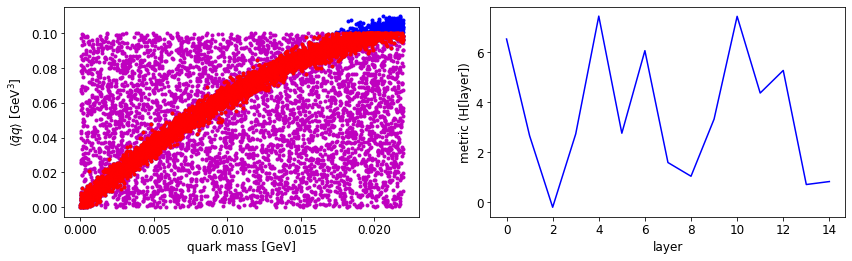

training epoch: 0,   loss: 0.31744325160980225
lambda: 0.17382028698921204,   AdS radius: 0.7811809182167053[1/GeV]
[ 6.512754    2.6571906  -0.19141628  2.7299018   7.4254107   2.7588155
  6.0486875   1.5903156   1.0441114   3.320307    7.4168267   4.360208
  5.261042    0.71415114  0.8322893 ]


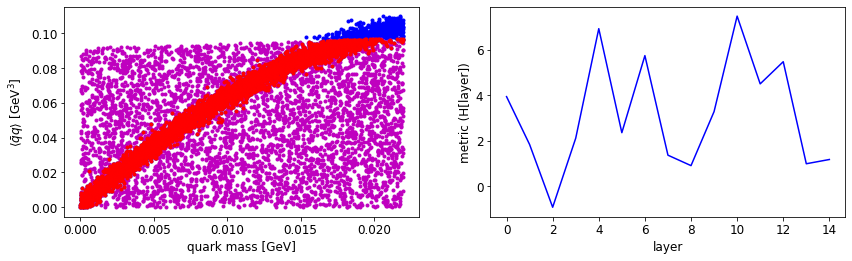

training epoch: 100,   loss: 0.2452373057603836
lambda: -1.255542516708374,   AdS radius: 0.9524512887001038[1/GeV]
[ 3.935084    1.8302882  -0.92573446  2.1085157   6.921345    2.3506227
  5.737377    1.3615563   0.90319186  3.2776847   7.472523    4.4958024
  5.4693737   0.9852931   1.1722997 ]


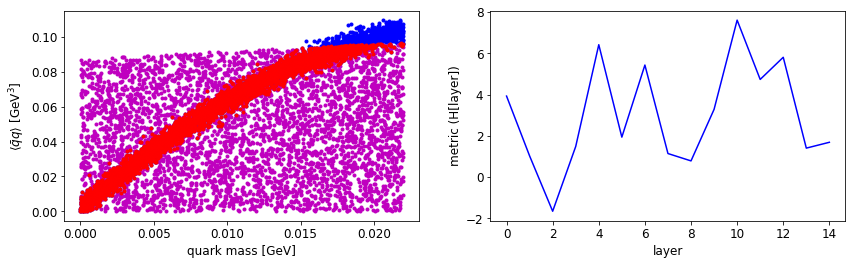

training epoch: 200,   loss: 0.23916761577129364
lambda: -2.846116065979004,   AdS radius: 1.0779869556427002[1/GeV]
[ 3.9243388  1.0276754 -1.6500783  1.4864657  6.4119105  1.9377236
  5.4273977  1.143297   0.7871906  3.2816436  7.601952   4.730898
  5.8031354  1.4055091  1.6880298]


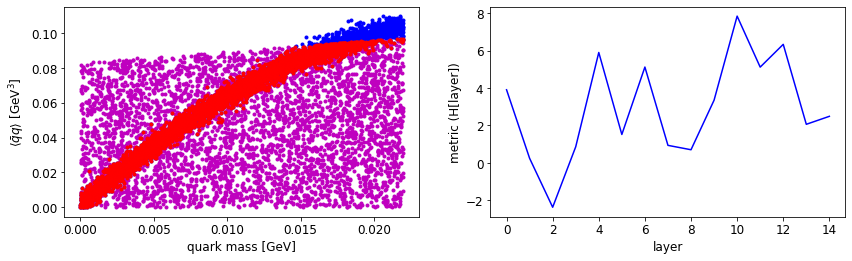

training epoch: 300,   loss: 0.23134879767894745
lambda: -4.771140098571777,   AdS radius: 1.2503002882003784[1/GeV]
[ 3.9046628   0.24500786 -2.3669543   0.8618516   5.8951244   1.5182251
  5.1178274   0.9369686   0.7025197   3.3483706   7.8366375   5.114114
  6.3300815   2.0610657   2.486836  ]


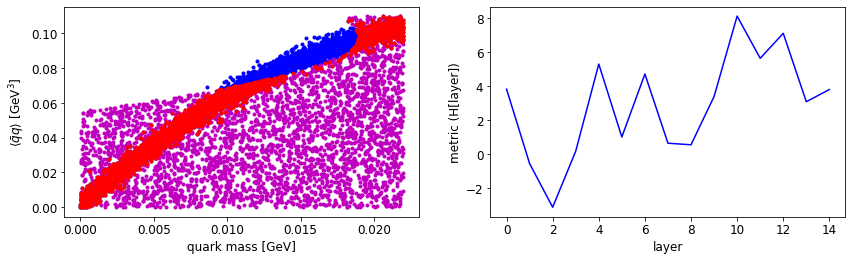

training epoch: 400,   loss: 0.19886325299739838
lambda: -7.342209339141846,   AdS radius: 1.8771662712097168[1/GeV]
[ 3.8421295  -0.5370549  -3.1058967   0.19381413  5.3176246   1.0276078
  4.734622    0.6624971   0.56884706  3.4094431   8.139983    5.6566606
  7.1271796   3.1044655   3.8207347 ]


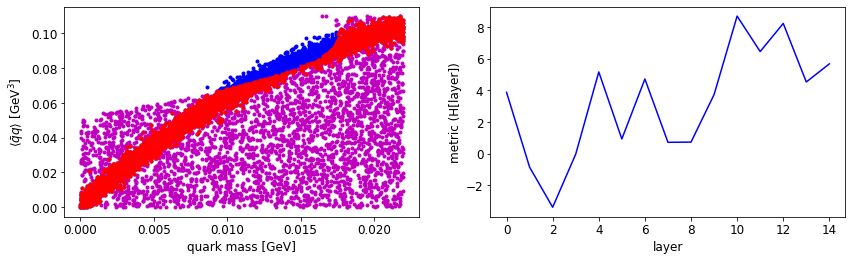

training epoch: 500,   loss: 0.18568183481693268
lambda: -6.920135021209717,   AdS radius: 1.8603289127349854[1/GeV]
[ 3.874528   -0.8446045  -3.37273    -0.02334372  5.1608634   0.9323993
  4.714525    0.7226928   0.73505384  3.731966    8.681485    6.4472456
  8.220107    4.527167    5.6712694 ]


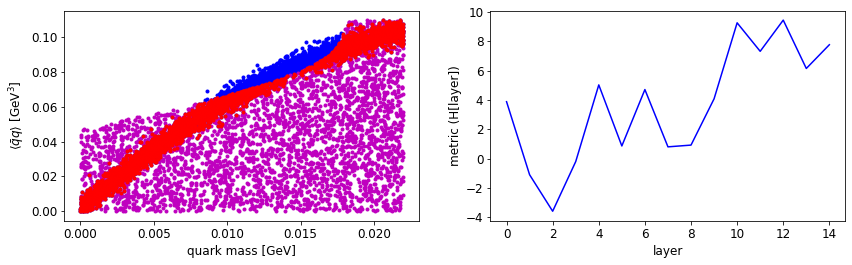

training epoch: 600,   loss: 0.1722826063632965
lambda: -6.377630710601807,   AdS radius: 1.83133065700531[1/GeV]
[ 3.8842852  -1.1076269  -3.600348   -0.20705903  5.0317307   0.8598789
  4.713177    0.7994837   0.9189358   4.080867    9.272957    7.3267517
  9.457807    6.154223    7.7762036 ]


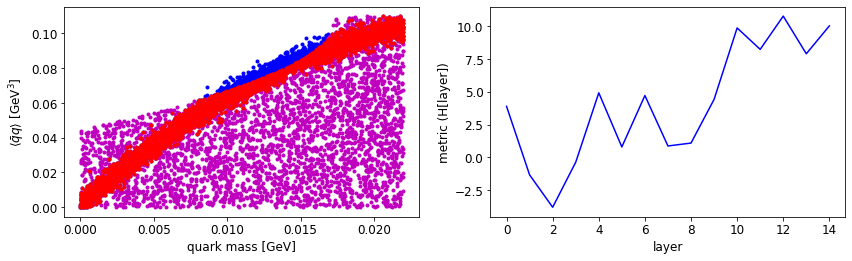

training epoch: 700,   loss: 0.16058561205863953
lambda: -5.730679512023926,   AdS radius: 1.8028508424758911[1/GeV]
[ 3.89154    -1.3286242  -3.7923825  -0.36256513  4.9226975   0.7999024
  4.7166877   0.8746051   1.0957829   4.421286    9.865865    8.233868
 10.766162    7.8974724  10.021653  ]


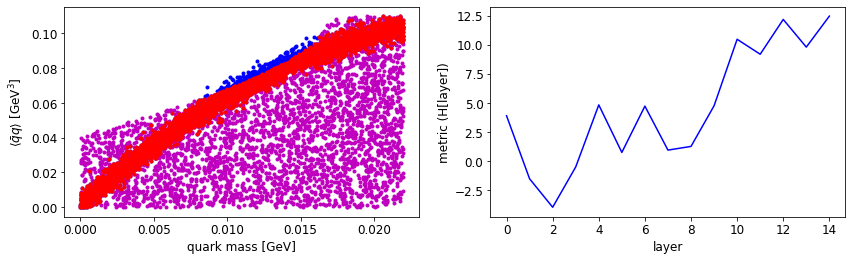

training epoch: 800,   loss: 0.149375319480896
lambda: -4.938050270080566,   AdS radius: 1.772606611251831[1/GeV]
[ 3.898345   -1.5151186  -3.9546506  -0.49381647  4.83163     0.7520676
  4.7262354   0.95050573  1.2691005   4.7577133  10.466728    9.180928
 12.16898     9.793803   12.454163  ]


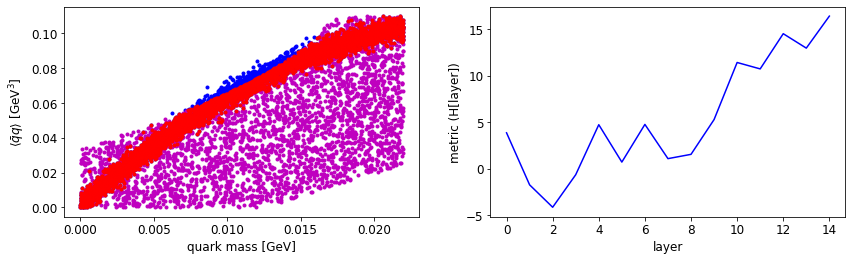

training epoch: 900,   loss: 0.1226523369550705
lambda: -3.3480453491210938,   AdS radius: 1.7881689071655273[1/GeV]
[ 3.8512104  -1.7455477  -4.154633   -0.6540203   4.72409     0.70215285
  4.7550993   1.0730941   1.5345303   5.273853   11.41379    10.723809
 14.5103855  12.959068   16.401266  ]


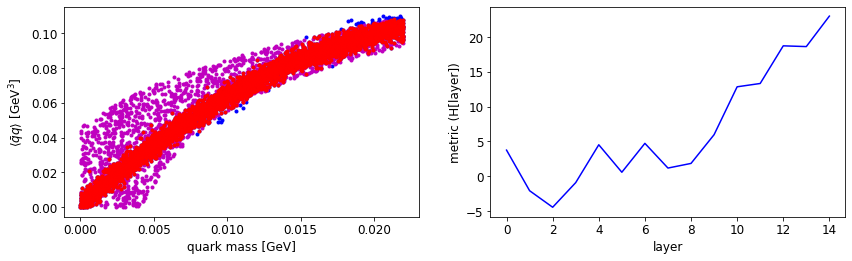

training epoch: 1000,   loss: 0.026632320135831833
lambda: 0.2710389792919159,   AdS radius: 2.6429457664489746[1/GeV]
[ 3.7393906  -2.101748   -4.4785557  -0.93238986  4.508847    0.5581658
  4.7135186   1.1590998   1.8270311   5.9583497  12.848982   13.326583
 18.742844   18.634983   23.018795  ]


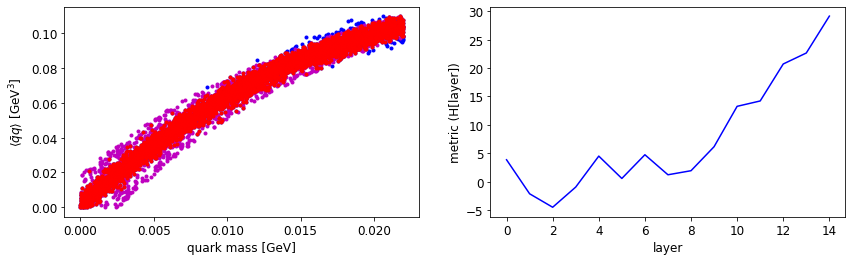

training epoch: 1100,   loss: 0.011050728149712086
lambda: 0.041916485875844955,   AdS radius: 3.050797462463379[1/GeV]
[ 3.8398018  -2.150096   -4.521758   -0.9676532   4.485245    0.54827243
  4.724198    1.1967583   1.9111675   6.1395483  13.250771   14.194798
 20.70833    22.64224    29.137754  ]


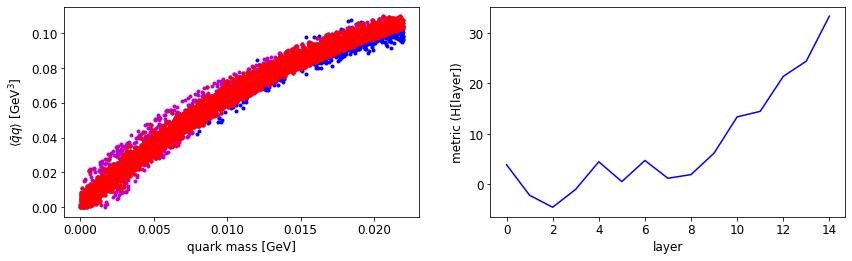

training epoch: 1200,   loss: 0.00806795246899128
lambda: 0.028291700407862663,   AdS radius: 3.200704336166382[1/GeV]
[ 3.885354   -2.1719859  -4.542017   -0.9855919   4.4707007   0.53778327
  4.7197194   1.2002203   1.928349    6.1857514  13.36481    14.461229
 21.386461   24.423216   33.336063  ]


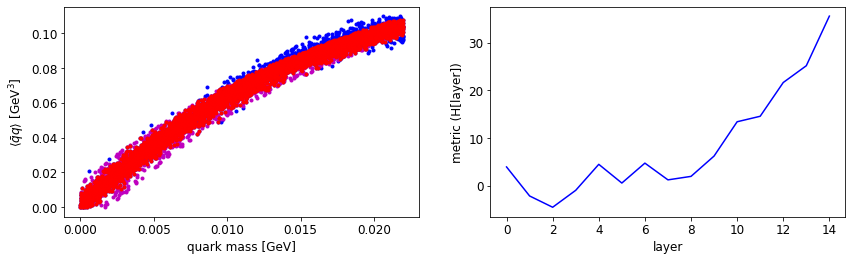

training epoch: 1300,   loss: 0.007305449340492487
lambda: 0.028578197583556175,   AdS radius: 3.1858625411987305[1/GeV]
[ 3.919138   -2.178654   -4.54788    -0.99048585  4.4671474   0.53585404
  4.720075    1.20362     1.9368886   6.2051234  13.409663   14.564225
 21.652964   25.178568   35.601784  ]


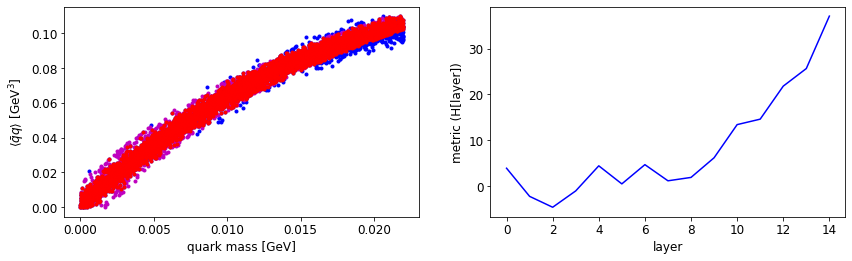

training epoch: 1400,   loss: 0.007831894792616367
lambda: 0.03134476765990257,   AdS radius: 3.1265454292297363[1/GeV]
[ 3.941327  -2.1850798 -4.5536795 -0.9956506  4.4628234  0.5326038
  4.7182317  1.203669   1.9400471  6.2147536 13.434564  14.624127
 21.812443  25.642252  37.056633 ]


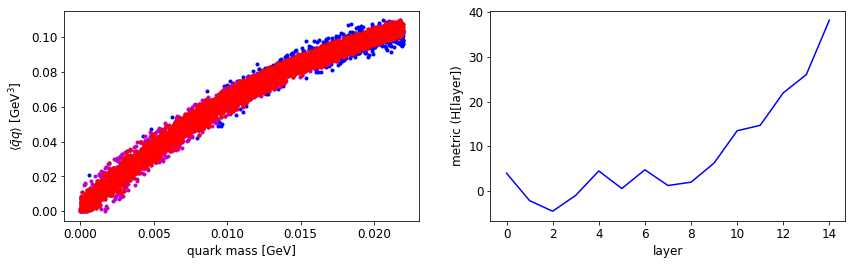

training epoch: 1500,   loss: 0.014333161525428295
lambda: 0.03787567466497421,   AdS radius: 3.0637400150299072[1/GeV]
[ 3.9582245  -2.1885374  -4.5565877  -0.99812555  4.4609003   0.53178465
  4.718349    1.2054428   1.9442567   6.2240753  13.455659   14.673088
 21.940151   26.014858   38.219414  ]


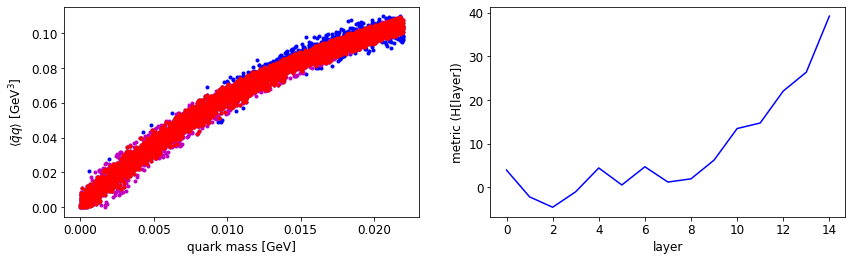

training epoch: 1600,   loss: 0.015281455591320992
lambda: 0.04432789608836174,   AdS radius: 3.003756523132324[1/GeV]
[ 3.948222   -2.1796043  -4.550299   -0.99929464  4.44067     0.5418571
  4.7071843   1.2122248   1.9505631   6.2325273  13.459075   14.724079
 22.031208   26.354485   39.18145   ]


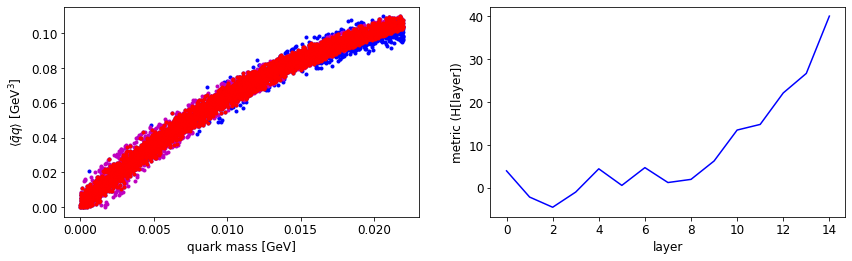

training epoch: 1700,   loss: 0.014136060141026974
lambda: 0.050525542348623276,   AdS radius: 2.9449243545532227[1/GeV]
[ 3.9402504  -2.1719089  -4.5454097  -1.0023532   4.4175367   0.55043834
  4.6933618   1.2170588   1.954629    6.238211   13.458019   14.769728
 22.109596   26.665298   40.028675  ]


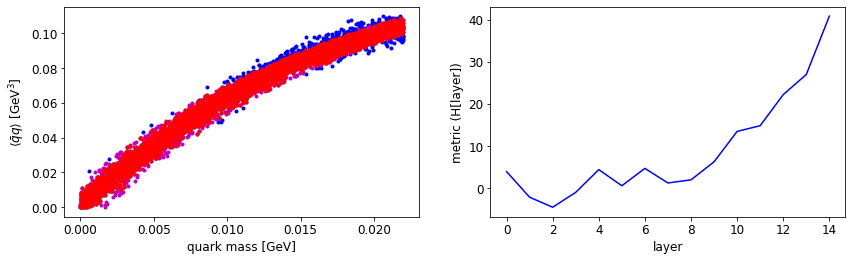

training epoch: 1800,   loss: 0.014337480999529362
lambda: 0.06050020083785057,   AdS radius: 2.8957834243774414[1/GeV]
[ 3.9364693 -2.1622071 -4.5386443 -1.0039891  4.39498    0.5608204
  4.680306   1.2233751  1.9599886  6.2448807 13.456861  14.815491
 22.184666  26.967394  40.820976 ]


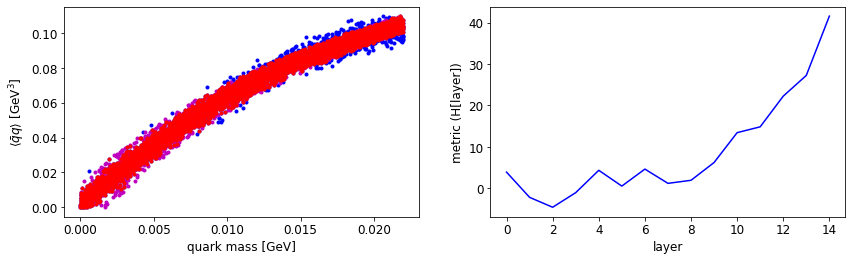

training epoch: 1900,   loss: 0.014061417430639267
lambda: 0.0701506957411766,   AdS radius: 2.842937469482422[1/GeV]
[ 3.9330711  -2.1537335  -4.533138   -1.0071454   4.3704853   0.56985563
  4.6654253   1.228173    1.9637065   6.2496533  13.453031   14.858143
 22.253355   27.25545    41.550526  ]


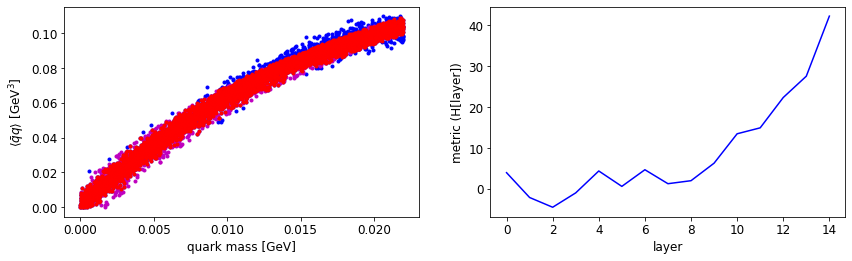

training epoch: 2000,   loss: 0.014328553341329098
lambda: 0.07727257907390594,   AdS radius: 2.7946670055389404[1/GeV]
[ 3.9324005 -2.143396  -4.5259533 -1.0090611  4.346348   0.5805459
  4.6511726  1.2343392  1.9686348  6.2553964 13.449186  14.901458
 22.320118  27.539274  42.23717  ]


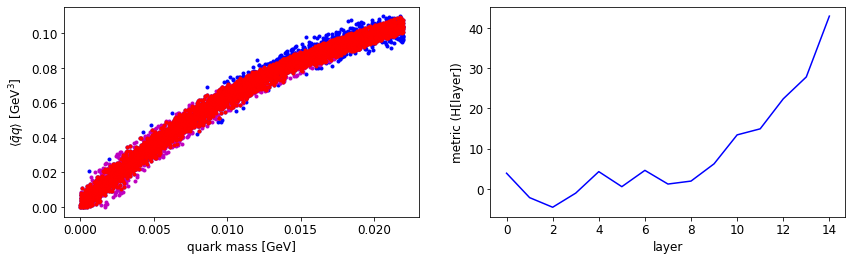

training epoch: 2100,   loss: 0.013760633766651154
lambda: 0.08977086842060089,   AdS radius: 2.7515764236450195[1/GeV]
[ 3.9307916  -2.134418   -4.520198   -1.012765    4.319841    0.58976686
  4.634795    1.2389061   1.971945    6.2594857  13.443342   14.944006
 22.38681    27.8287     42.925514  ]


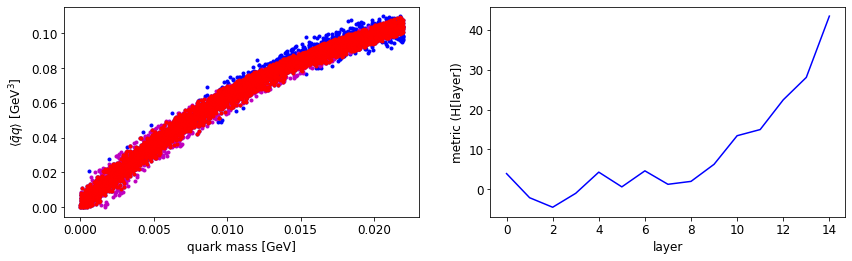

training epoch: 2200,   loss: 0.014279430732131004
lambda: 0.10005409270524979,   AdS radius: 2.701878070831299[1/GeV]
[ 3.9310327 -2.1238039 -4.5129004 -1.0151857  4.29416    0.6003229
  4.619169   1.244414   1.9758371  6.2633557 13.435322  14.98099
 22.436365  28.06607   43.44335  ]


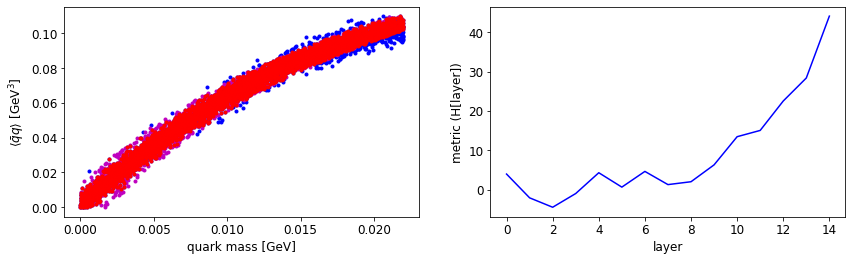

training epoch: 2300,   loss: 0.01407497376203537
lambda: 0.11232544481754303,   AdS radius: 2.6641383171081543[1/GeV]
[ 3.9294777 -2.1149552 -4.507459  -1.0198882  4.265496   0.6091018
  4.601012   1.2481974  1.9781889  6.2661734 13.427002  15.022012
 22.499077  28.349964  44.081333 ]


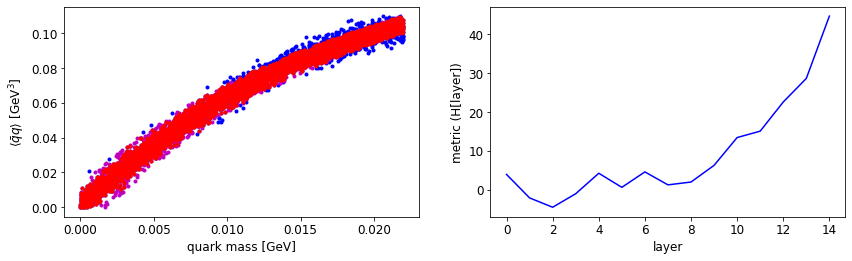

training epoch: 2400,   loss: 0.013599845580756664
lambda: 0.12942810356616974,   AdS radius: 2.6287574768066406[1/GeV]
[ 3.9298816 -2.1039078 -4.4999743 -1.0230289  4.237569   0.6197763
  4.583755   1.253515   1.9818277  6.269788  13.417962  15.061539
 22.553926  28.611277  44.634624 ]


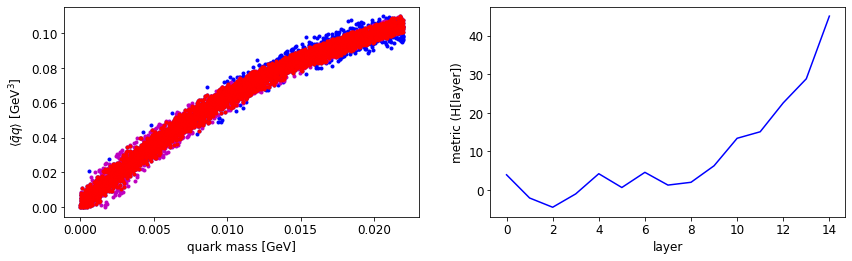

training epoch: 2500,   loss: 0.013770691119134426
lambda: 0.14447727799415588,   AdS radius: 2.5875914096832275[1/GeV]
[ 3.9301147 -2.093105  -4.492684  -1.0263193  4.2097816  0.6301123
  4.5664883  1.2585175  1.985097   6.2727795 13.407993  15.09834
 22.602797  28.852043  45.120155 ]


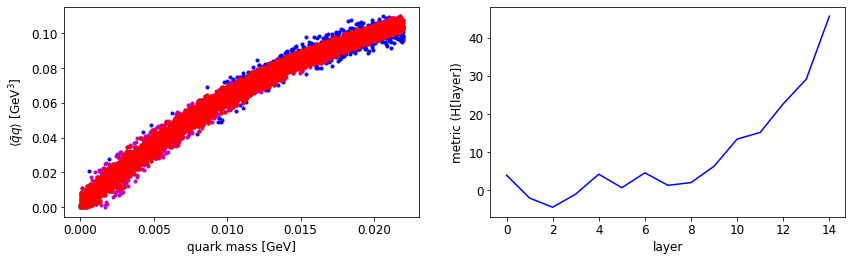

training epoch: 2600,   loss: 0.013595500029623508
lambda: 0.15460051596164703,   AdS radius: 2.554154634475708[1/GeV]
[ 3.9303071  -2.081586   -4.4849277  -1.0300146   4.1799593   0.64096415
  4.5478497   1.2637367   1.9885688   6.2760687  13.397869   15.139226
 22.660124   29.12233    45.657005  ]


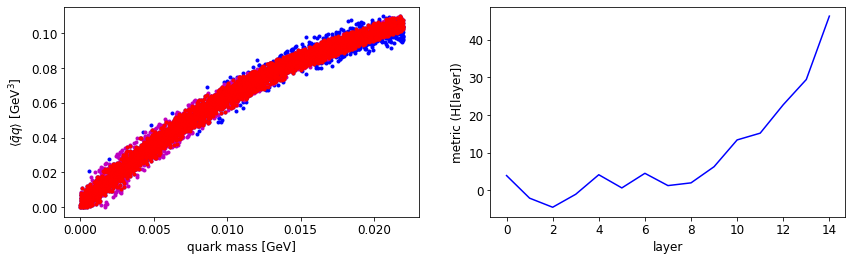

training epoch: 2700,   loss: 0.01340531837195158
lambda: 0.1724122166633606,   AdS radius: 2.526806592941284[1/GeV]
[ 3.929718  -2.0707028 -4.477894  -1.0347456  4.148638   0.6511063
  4.528021   1.2682769  1.9914777  6.2790117 13.3877535 15.182735
 22.725365  29.419659  46.24312  ]


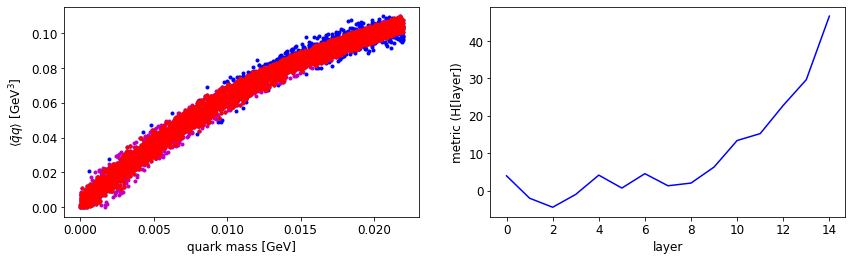

training epoch: 2800,   loss: 0.013732653111219406
lambda: 0.18681219220161438,   AdS radius: 2.49363374710083[1/GeV]
[ 3.9310768 -2.0577    -4.468773  -1.0376029  4.119102   0.6629535
  4.509678   1.2741439  1.9953057  6.2819333 13.375509  15.219029
 22.76876   29.645441  46.640995 ]


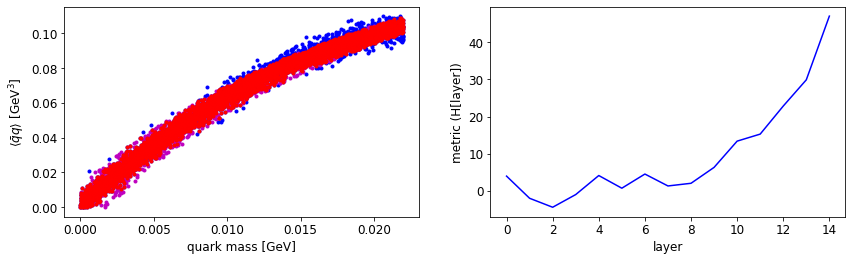

training epoch: 2900,   loss: 0.013347409665584564
lambda: 0.21101845800876617,   AdS radius: 2.465190887451172[1/GeV]
[ 3.9311945  -2.045509   -4.460543   -1.0418124   4.0875483   0.67385197
  4.4897203   1.279008    1.9981748   6.283996   13.362315   15.256568
 22.816568   29.889008   47.06496   ]


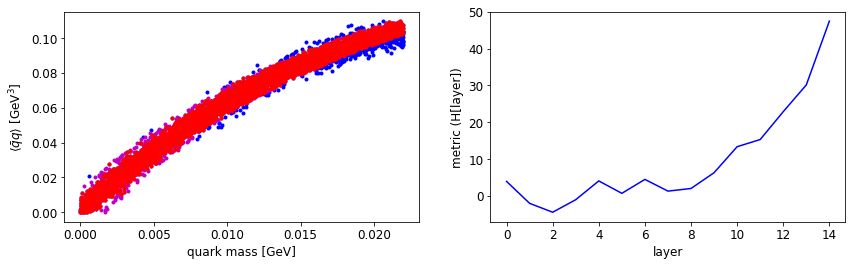

training epoch: 3000,   loss: 0.07764991372823715
lambda: 0.22517120838165283,   AdS radius: 2.4333438873291016[1/GeV]
[ 3.9267488  -2.032617   -4.4519916  -1.0469193   4.0527425   0.68501186
  4.467281    1.2834636   2.0003152   6.284819   13.345645   15.292832
 22.858322   30.122168   47.446037  ]


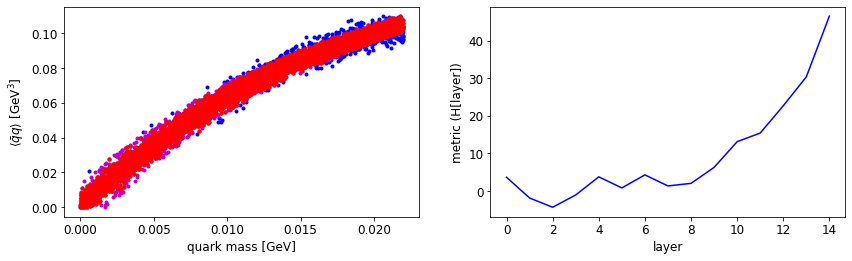

training epoch: 3100,   loss: 0.06997101753950119
lambda: 0.24246476590633392,   AdS radius: 2.42024564743042[1/GeV]
[ 3.649775   -1.8682204  -4.322043   -1.0546031   3.7668145   0.82009333
  4.286183    1.3452308   2.03026     6.275045   13.118157   15.414623
 22.655058   30.353168   46.517605  ]


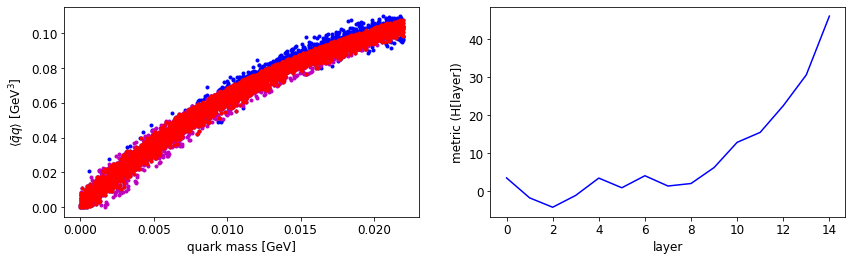

training epoch: 3200,   loss: 0.06534017622470856
lambda: 0.2501513361930847,   AdS radius: 2.4111061096191406[1/GeV]
[ 3.5243204 -1.7287989 -4.203029  -1.0797809  3.4811273  0.9289797
  4.1001225  1.3899068  2.048773   6.252513  12.897966  15.524107
 22.536818  30.676659  46.158615 ]


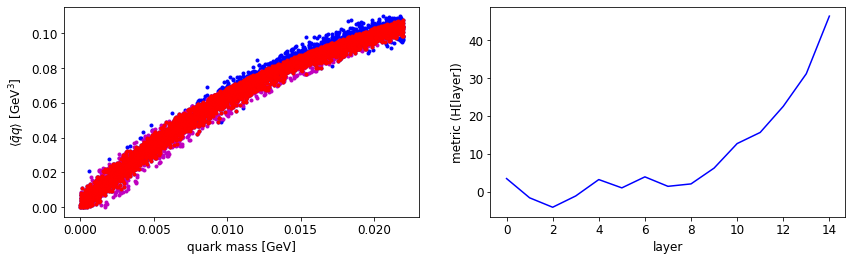

training epoch: 3300,   loss: 0.06169579178094864
lambda: 0.250663697719574,   AdS radius: 2.4129252433776855[1/GeV]
[ 3.4704866 -1.6061586 -4.0927043 -1.1169261  3.2039323  1.0144674
  3.9163122  1.4213219  2.0599284  6.2225013 12.692711  15.626996
 22.50425   31.108744  46.29548  ]


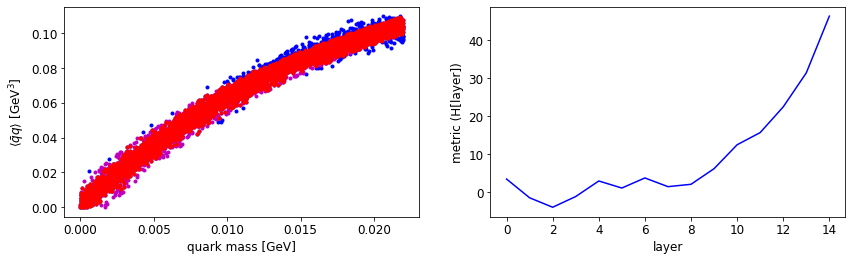

training epoch: 3400,   loss: 0.0579683892428875
lambda: 0.24549897015094757,   AdS radius: 2.4111156463623047[1/GeV]
[ 3.45107   -1.4915001 -3.9856985 -1.159578   2.9398549  1.0821791
  3.7390268  1.443654   2.0663989  6.1856694 12.495575  15.704999
 22.485771  31.45827   46.419323 ]


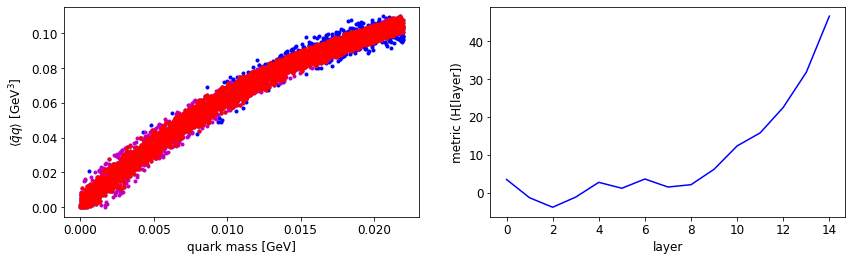

training epoch: 3500,   loss: 0.05566410720348358
lambda: 0.24400515854358673,   AdS radius: 2.4104604721069336[1/GeV]
[ 3.448519  -1.3828486 -3.8815887 -1.202552   2.6972804  1.1352205
  3.5753827  1.4606494  2.0720167  6.147946  12.315725  15.767337
 22.492245  31.771137  46.605633 ]


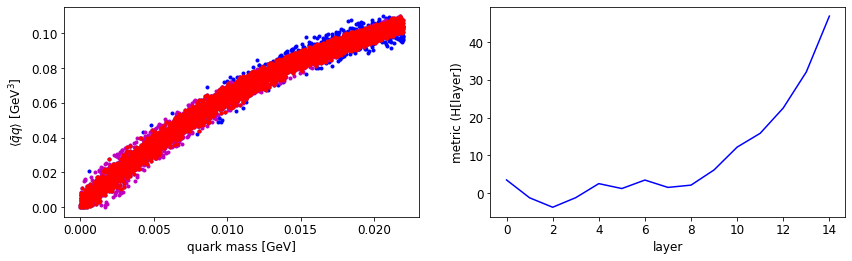

training epoch: 3600,   loss: 0.052772000432014465
lambda: 0.24087227880954742,   AdS radius: 2.41251802444458[1/GeV]
[ 3.45332   -1.2801452 -3.7812407 -1.2438866  2.4778516  1.1756063
  3.4269657  1.4737055  2.0777469  6.111562  12.155217  15.819482
 22.524006  32.07383   46.881016 ]


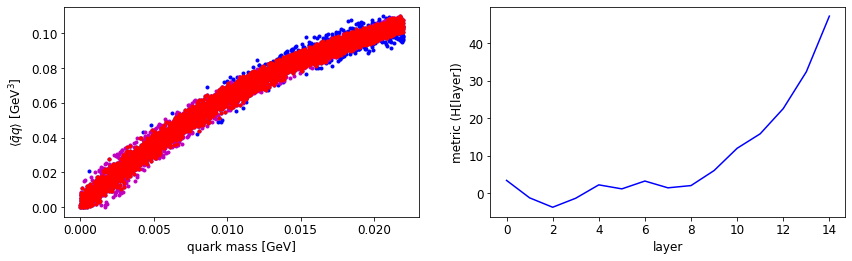

training epoch: 3700,   loss: 0.050269145518541336
lambda: 0.23251351714134216,   AdS radius: 2.412217855453491[1/GeV]
[ 3.46131   -1.1807644 -3.6826212 -1.2838528  2.2750885  1.2059243
  3.2894268  1.4836465  2.0834863  6.075592  12.007863  15.86172
 22.568289  32.350563  47.178566 ]


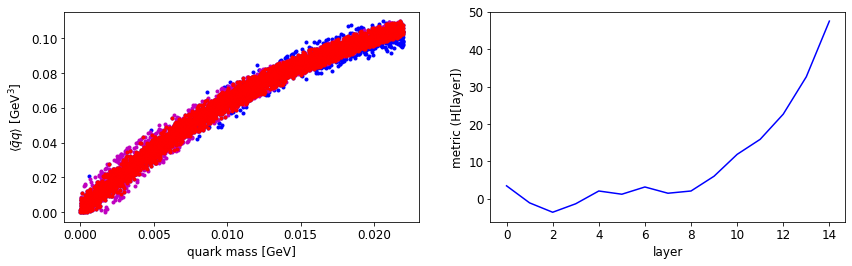

training epoch: 3800,   loss: 0.047922369092702866
lambda: 0.234380841255188,   AdS radius: 2.4176881313323975[1/GeV]
[ 3.4689958 -1.0865793 -3.5879216 -1.3235356  2.0867875  1.2256708
  3.1607196  1.4891585  2.0874062  6.038597  11.870903  15.8931875
 22.617434  32.595783  47.46632  ]


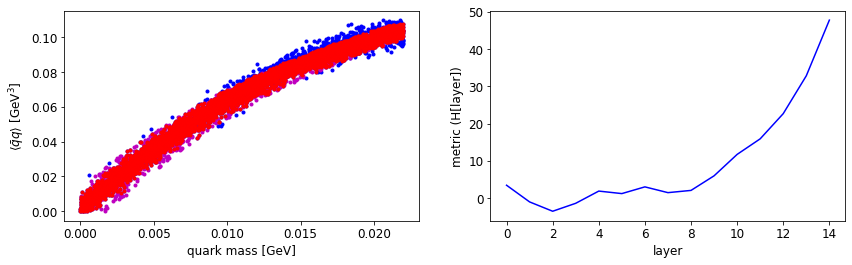

training epoch: 3900,   loss: 0.046081677079200745
lambda: 0.22789226472377777,   AdS radius: 2.420802354812622[1/GeV]
[ 3.4803386  -0.99082416 -3.4905221  -1.3587661   1.9124776   1.2410527
  3.04209     1.4954834   2.094352    6.0047007  11.744991   15.919984
 22.672892   32.81897    47.739365  ]


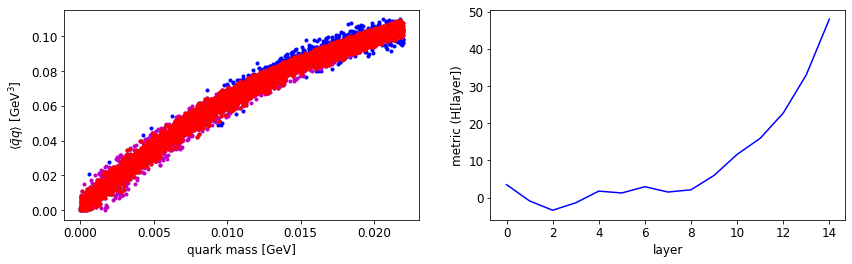

training epoch: 4000,   loss: 0.044747766107320786
lambda: 0.2224423736333847,   AdS radius: 2.4190359115600586[1/GeV]
[ 3.4897957 -0.899191  -3.3962095 -1.3940731  1.747563   1.2477435
  2.9288423  1.4978527  2.0992734  5.969268  11.625191  15.93795
 22.727076  33.015533  47.988155 ]


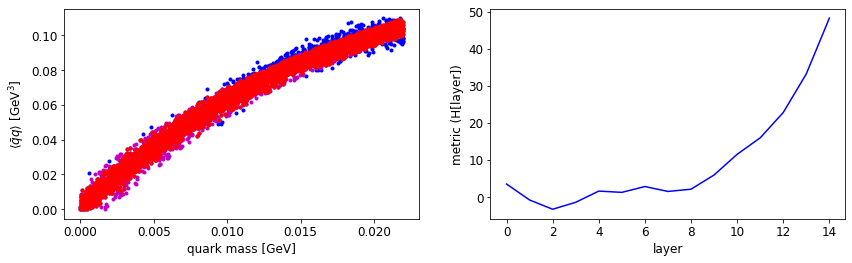

training epoch: 4100,   loss: 0.04291569069027901
lambda: 0.21661919355392456,   AdS radius: 2.420213222503662[1/GeV]
[ 3.4994333 -0.810129  -3.3035681 -1.4271233  1.5939839  1.2485758
  2.822993   1.4986472  2.1043508  5.9350805 11.514443  15.952217
 22.786465  33.205627  48.25038  ]


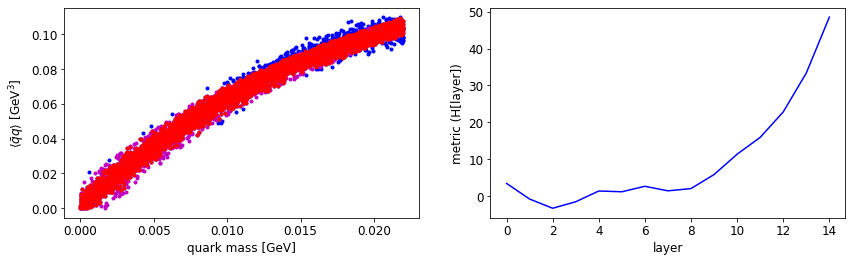

training epoch: 4200,   loss: 0.04224865138530731
lambda: 0.2159310281276703,   AdS radius: 2.423476457595825[1/GeV]
[ 3.5083497 -0.7251627 -3.2142684 -1.4581869  1.4516064  1.2437351
  2.7242327  1.4973888  2.1087174  5.9016023 11.411716  15.961533
 22.844748  33.37844   48.49525  ]


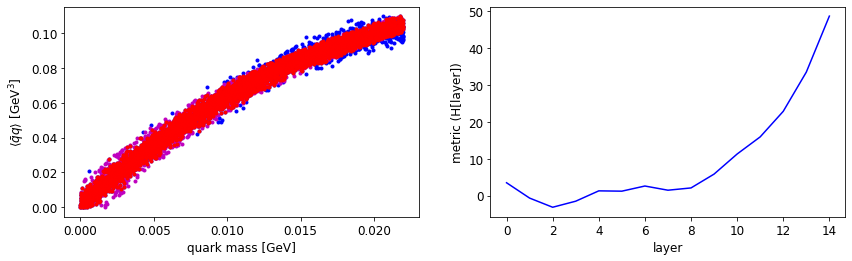

training epoch: 4300,   loss: 0.040389593690633774
lambda: 0.21043074131011963,   AdS radius: 2.422621726989746[1/GeV]
[ 3.516325   -0.64411086 -3.1282039  -1.4872199   1.3193653   1.234201
  2.6319559   1.4945302   2.1126142   5.8691897  11.316665   15.9676
 22.903404   33.543633   48.7418    ]


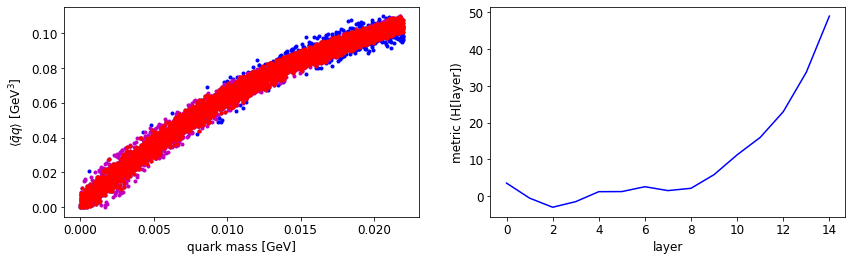

training epoch: 4400,   loss: 0.039410706609487534
lambda: 0.20775216817855835,   AdS radius: 2.427125930786133[1/GeV]
[ 3.5246825  -0.56517506 -3.0436351  -1.5137924   1.1956824   1.2213055
  2.5453086   1.4910511   2.1169329   5.838444   11.2287855  15.973258
 22.966906   33.714878   49.013214  ]


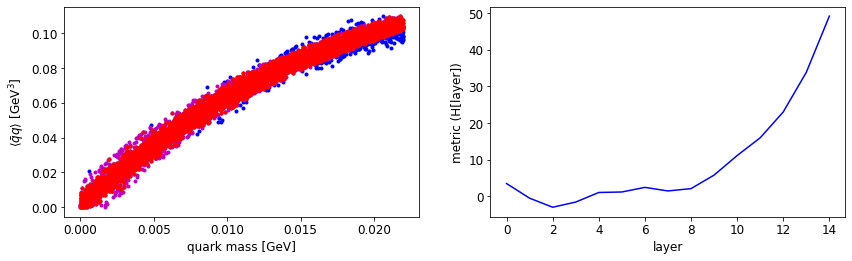

training epoch: 4500,   loss: 0.30082154273986816
lambda: 0.20241679251194,   AdS radius: 2.4298946857452393[1/GeV]
[ 3.5068505 -0.479838  -2.9515808 -1.5376006  1.0728451  1.206165
  2.4592023  1.4882984  2.1231656  5.8072724 11.13908   15.971603
 23.015686  33.82324   49.1325   ]


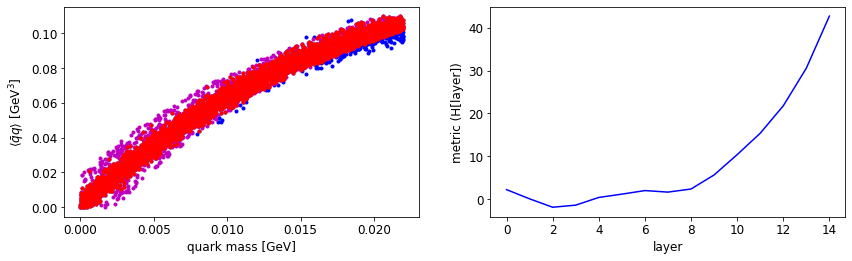

training epoch: 4600,   loss: 0.16615799069404602
lambda: 0.13836601376533508,   AdS radius: 2.5663468837738037[1/GeV]
[ 2.1920724   0.04447216 -1.9202205  -1.428375    0.36857095  1.1407803
  1.9774091   1.6146462   2.340799    5.6207457  10.366347   15.363463
 21.771606   30.565088   42.742897  ]


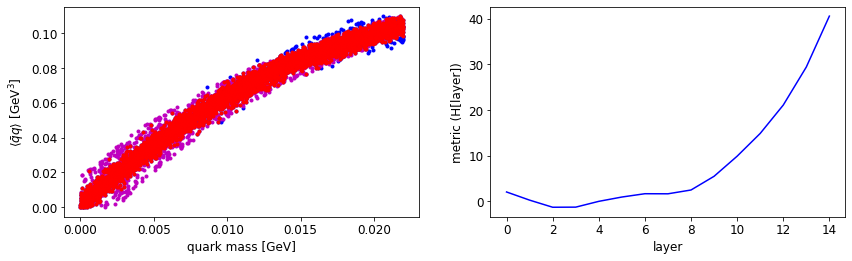

training epoch: 4700,   loss: 0.13806460797786713
lambda: 0.06817387044429779,   AdS radius: 2.8187081813812256[1/GeV]
[ 2.0093386   0.21978891 -1.3393574  -1.3169196  -0.04568601  0.89838475
  1.626818    1.6092091   2.4425046   5.44837     9.855728   14.845675
 21.063517   29.40866    40.578434  ]


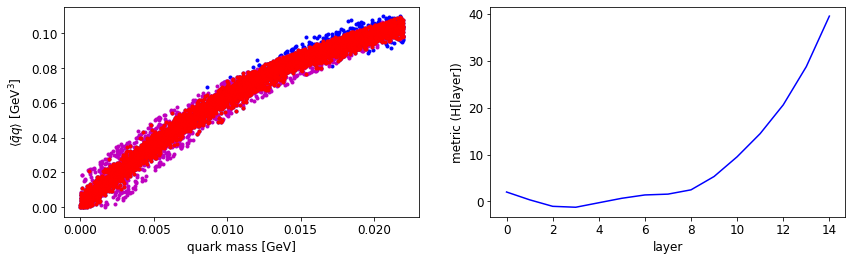

training epoch: 4800,   loss: 0.1252356320619583
lambda: 0.0356878861784935,   AdS radius: 3.061049222946167[1/GeV]
[ 2.0201302   0.35822898 -1.0302322  -1.2265579  -0.26968366  0.6832982
  1.3921047   1.5680171   2.4810746   5.3210163   9.525393   14.461023
 20.582064   28.726137   39.488262  ]


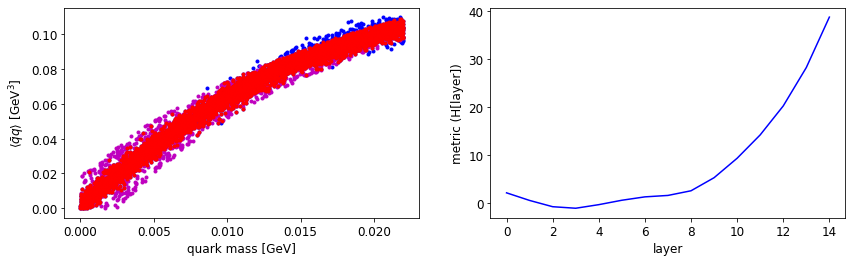

training epoch: 4900,   loss: 0.11734553426504135
lambda: 0.022350335493683815,   AdS radius: 3.2493462562561035[1/GeV]
[ 2.0630834   0.47453153 -0.8346989  -1.1551847  -0.4056149   0.5141386
  1.2216941   1.5218339   2.4935937   5.224105    9.28997    14.16713
 20.218227   28.236305   38.772926  ]


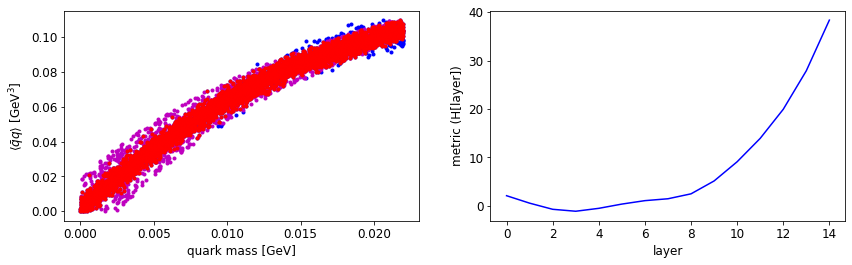

training epoch: 5000,   loss: 0.11161572486162186
lambda: 0.01540602557361126,   AdS radius: 3.380021333694458[1/GeV]
[ 2.1089745   0.5719024  -0.69475734 -1.097111   -0.49621373  0.38021657
  1.089801    1.4777186   2.4946408   5.1475735   9.111433   13.937009
 19.938086   27.88621    38.339508  ]


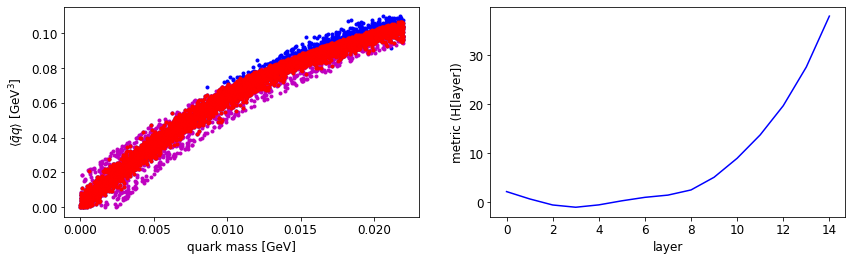

training epoch: 5100,   loss: 0.1081789955496788
lambda: 0.013268372975289822,   AdS radius: 3.4643750190734863[1/GeV]
[ 2.1549337   0.65909725 -0.5807791  -1.0447633  -0.56146795  0.26898223
  0.98038626  1.4368896   2.4913642   5.0839014   8.965367   13.74489
 19.707916   27.61552    38.02578   ]


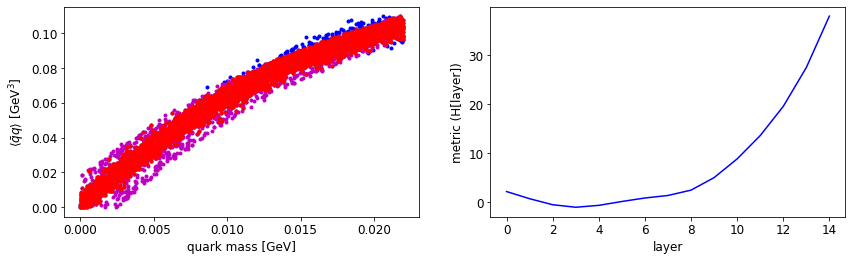

training epoch: 5200,   loss: 0.10475979000329971
lambda: 0.0093162776902318,   AdS radius: 3.543130874633789[1/GeV]
[ 2.1975222   0.7370086  -0.4841126  -0.99819845 -0.61363935  0.17017461
  0.8823434   1.3957473   2.4831834   5.026415    8.838554   13.578361
 19.517597   27.42369    37.896946  ]


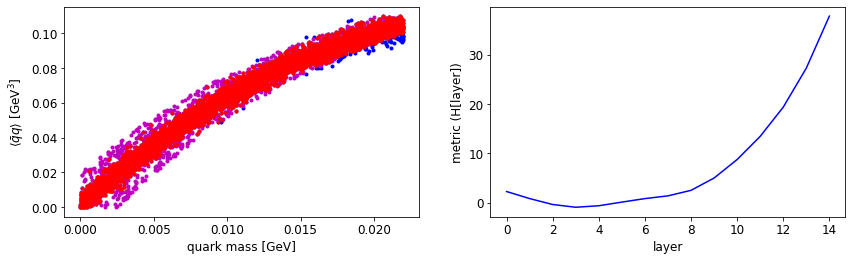

training epoch: 5300,   loss: 0.10159744322299957
lambda: 0.007850383408367634,   AdS radius: 3.5895562171936035[1/GeV]
[ 2.235171    0.8047469  -0.4027454  -0.9574043  -0.6546948   0.08487388
  0.7965179   1.3564155   2.4720767   4.9756317   8.730081   13.436249
 19.360971   27.2845     37.845898  ]


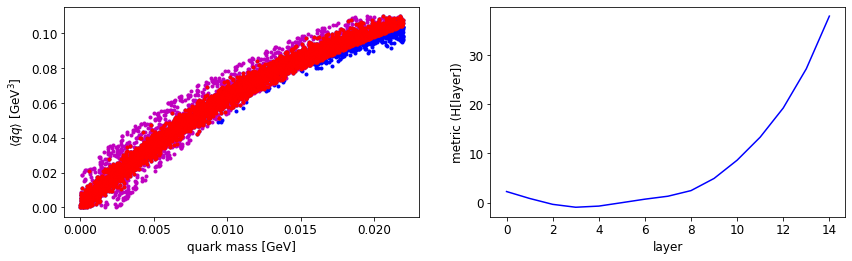

training epoch: 5400,   loss: 0.09978065639734268
lambda: 0.006572149693965912,   AdS radius: 3.6193904876708984[1/GeV]
[ 2.2698328e+00  8.6592811e-01 -3.3079514e-01 -9.1974986e-01
 -6.8752623e-01  9.8820571e-03  7.1984160e-01  1.3192081e+00
  2.4599578e+00  4.9305859e+00  8.6358585e+00  1.3314273e+01
  1.9234861e+01  2.7199396e+01  3.7893520e+01]


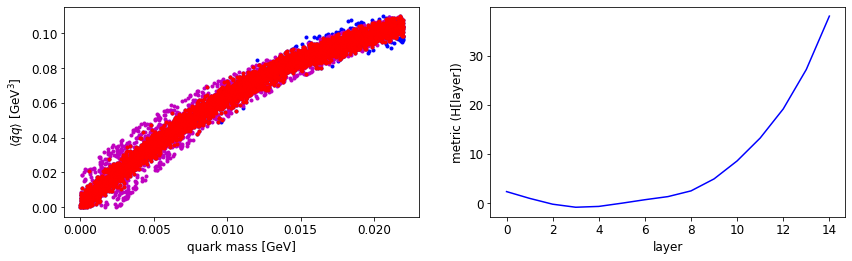

training epoch: 5500,   loss: 0.09786269813776016
lambda: 0.007846294902265072,   AdS radius: 3.655211925506592[1/GeV]
[ 2.3030684   0.9235871  -0.26395378 -0.8833252  -0.7146378  -0.05845732
  0.64869124  1.2830714   2.4470768   4.8893747   8.551163   13.206462
 19.132643   27.160522   38.02569   ]


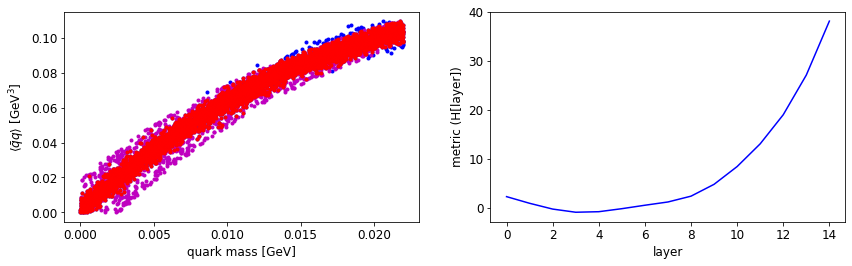

training epoch: 5600,   loss: 0.09660564363002777
lambda: 0.0065056090243160725,   AdS radius: 3.68208646774292[1/GeV]
[ 2.335699    0.97914535 -0.20020413 -0.8471003  -0.73682797 -0.12128904
  0.58186     1.247696    2.4334495   4.8505673   8.472604   13.107003
 19.041815   27.133186   38.13939   ]


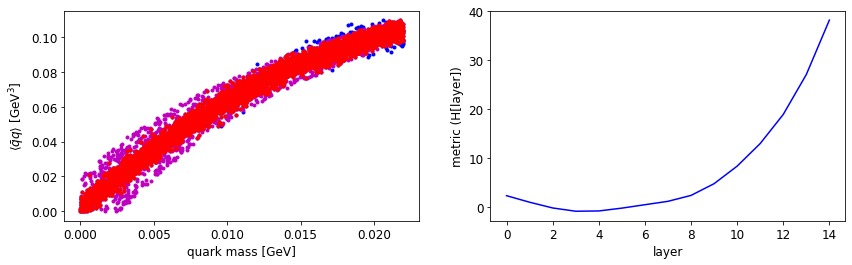

training epoch: 5700,   loss: 0.09492415189743042
lambda: 0.007111395709216595,   AdS radius: 3.686725378036499[1/GeV]
[ 2.3640232   1.028313   -0.14378357 -0.8147323  -0.7563723  -0.17915256
  0.51909536  1.2121809   2.4175298   4.8130736   8.400047   13.01632
 18.961636   27.112947   38.237644  ]


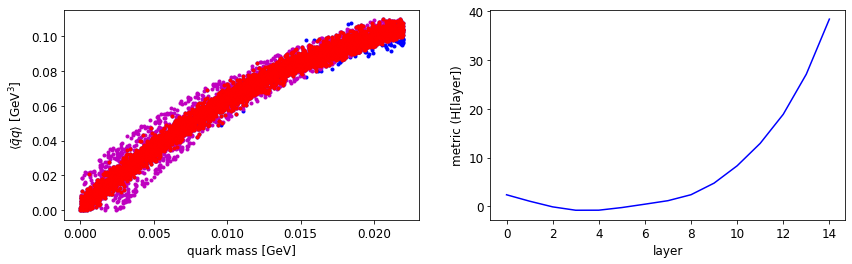

training epoch: 5800,   loss: 0.09307598322629929
lambda: 0.006195735651999712,   AdS radius: 3.696072578430176[1/GeV]
[ 2.391134    1.0748041  -0.0905738  -0.7830671  -0.7720168  -0.23152912
  0.46104893  1.1784437   2.4020848   4.7791395   8.335364   12.937802
 18.901543   27.13114    38.431652  ]


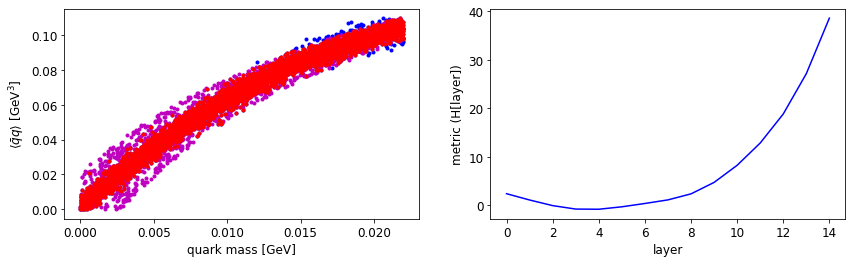

training epoch: 5900,   loss: 0.09203962236642838
lambda: 0.006831571459770203,   AdS radius: 3.7139928340911865[1/GeV]
[ 2.4176335   1.1201456  -0.0386481  -0.75147253 -0.7858673  -0.28232095
  0.4035014   1.1435301   2.3849328   4.745047    8.272329   12.862639
 18.847963   27.158642   38.6154    ]


In [83]:
total_epoch=6000
show_epoch_each=100

for epoch in range(total_epoch):
    if epoch==0:
        regularization_coeffs = [0]
        for i in range(1, N_layer):
            regularization_coeffs.append(0.0*eta(i, eta_ini, eta_fin, N_layer)**4)
    if epoch==1500:
        regularization_coeffs = [0]
        for i in range(1, N_layer):
            regularization_coeffs.append(0.0001*eta(i, eta_ini, eta_fin, N_layer)**4)
    if epoch==3000:
        regularization_coeffs = [0]
        for i in range(1, N_layer):
            regularization_coeffs.append(0.001*eta(i, eta_ini, eta_fin, N_layer)**4)
    if epoch==4500:
        regularization_coeffs = [0]
        for i in range(1, N_layer):
            regularization_coeffs.append(0.01*eta(i, eta_ini, eta_fin, N_layer)**4)
    batches = iter(train_d_loader)
    train_loss = 0.0
    for (b_phi, b_Pi, b_ans) in batches:
        # (b_phi, b_Pi, b_ans) is a minibatch, we need to convert it to `Variable` object. 
        phi, Pi, ans = Variable(b_phi), Variable(b_Pi), Variable(b_ans)
        # calclation of loss
        loss = Test.loss(phi=phi, Pi=Pi, answer=ans, reg_coef_list=regularization_coeffs)
        # update
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        train_loss += loss.data[0]
    if np.isnan(train_loss)==True: break

    if epoch % show_epoch_each == 0:
        negx, negy, posx, posy, Hs = plot_phase_and_metric(
                                                           threshold=.1, eta_or_layer='layer',
                                                           positive_H_M_F=positive_H_M_F,
                                                           negative_H_M_F=negative_H_M_F,
                                                           Net=Test
                                                          )
        print ("training epoch: {},   loss: {}".format(epoch, train_loss / len(train_d_loader)))
        print ("lambda: {},   AdS radius: {}[1/GeV]".format(Test.show_lamb().data.numpy()[0], Test.show_adsradius().data.numpy()[0]))
        print(np.array([Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layers)]))

In [ ]:
a=[Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layers)]
print(np.array(a))
print(c_reg1)

# 4. Save & load NN

Create a directry named "trained_models" by running the following cell:

In [ ]:
%%bash
mkdir trained_models

Instance "Test" of the trained MetricNet is saved there by using `torch.save`.

In [ ]:
torch.save(Test, 'trained_models/name.pt') 

To load a saved model, use `torch.load`.

In [ ]:
model = torch.load('trained_models/name.pt')

# 5. How to get trained parameters of the NN

To get the parameters as numpy array, use:

In [ ]:
model.adsradius.weight.data.numpy() # AdS radius in unit [GeV^{-1}]

In [ ]:
model.lamb.weight.data.numpy() # lambda

In [ ]:
for h in model.Hs:     # metric (h)
    np_h = h.weight.data.numpy()
    print(np_h)